# Part 4 - Fun With Convolutional Networks

In Parts 2 & 3 we applied a 3-layer perceptron (with 400, 150 hidden units) to the MNIST and Fashion-MNIST respectively. In terms of numbers of layers, this is probably the smallest network you could describe as 'deep learning' but as we've seen it does a decent job, giving a similar level of performance to state-of-the-art SVMs. 

Let's move on to a convolutional network. Given the significant increase in model complexity, we'd really hope to do a better job than the 3-layer perceptron and the SVM models. Quite often, you see Keras tutorials on this same dataset with very complex convolutional network (which Keras makes easy to do) but those models frequently don't actually get any better performance on the task than we've managed to do with the 3-layer perceptron, or could be done with other machine learning models, like an SVM (but with a massively increased training time).

Let's build a couple of convolutional models and see see how our performance compares to the previous model on both datasets.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from tensorflow.python.framework import ops
from preprocess_conv import random_mini_batches

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

mnist = tf.keras.datasets.mnist
fashion_mnist = tf.keras.datasets.fashion_mnist


/home/nickdbn/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


As we did previously (parts 2 and 3), we're going to import the MNIST and the Fashion MNIST in parallel. To be clear - we're going to train separate models on each dataset, but here we're loading and processing the data all together.

In [2]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [3]:
(f_x_train, f_y_train_orig),(f_x_test, f_y_test_orig) = fashion_mnist.load_data()
(d_x_train, d_y_train_orig), (d_x_test, d_y_test_orig) = mnist.load_data()

f_x_train, f_x_test = f_x_train / 255.0, f_x_test / 255.0 # normalise
d_x_train, d_x_test = d_x_train / 255.0, d_x_test / 255.0 # normalise

# reshape y to arrays of shape (m,1)
#f_y_train, f_y_test = f_y_train.reshape(f_y_train.shape[0], 1), f_y_test.reshape(f_y_test.shape[0], 1)
#d_y_train, d_y_test = d_y_train.reshape(d_y_train.shape[0], 1), d_y_test.reshape(d_y_test.shape[0], 1)

f_x_train = f_x_train.reshape(f_x_train.shape[0], f_x_train.shape[1], f_x_train.shape[2], 1)
f_x_test = f_x_test.reshape(f_x_test.shape[0], f_x_test.shape[1], f_x_test.shape[2], 1)
d_x_train = d_x_train.reshape(d_x_train.shape[0], d_x_train.shape[1], d_x_train.shape[2], 1)
d_x_test = d_x_test.reshape(d_x_test.shape[0], d_x_test.shape[1], d_x_test.shape[2], 1)

f_y_train = convert_to_one_hot(f_y_train_orig, 10).T
f_y_test = convert_to_one_hot(f_y_test_orig, 10).T
d_y_train = convert_to_one_hot(d_y_train_orig, 10).T
d_y_test = convert_to_one_hot(d_y_test_orig, 10).T


print ("f_x_train shape:", f_x_train.shape)
print ("f_y_train shape:", f_y_train.shape)
print ("f_x_test shape:", f_x_test.shape)
print ("f_y_test shape:", f_y_test.shape)
print ("d_x_train shape:", d_x_train.shape)
print ("d_y_train shape:", d_y_train.shape)
print ("d_x_test shape:", d_x_test.shape)
print ("d_y_test shape:", d_y_test.shape)

f_x_train shape: (60000, 28, 28, 1)
f_y_train shape: (60000, 10)
f_x_test shape: (10000, 28, 28, 1)
f_y_test shape: (10000, 10)
d_x_train shape: (60000, 28, 28, 1)
d_y_train shape: (60000, 10)
d_x_test shape: (10000, 28, 28, 1)
d_y_test shape: (10000, 10)


In [4]:
# Temporary - code broken by changing dimensionalty of X data to [m, h, w, c] where c =1

#display_examples_n = 40
#rows = 6
#cols = 8
#fig, axarr = plt.subplots(rows, cols)
#
#for r in range (0, rows):
#    for c in range (0, cols):
#        axarr[r][c].title.set_text(str(f_y_train_orig[(r*cols)+c]))
#        axarr[r][c].imshow(f_x_train[(r*cols)+c])
        
#for r in range (3, rows):
#    for c in range (0, cols):
#        axarr[r][c].title.set_text(str(d_y_train_orig[(r*cols)+c]))
#        axarr[r][c].imshow(d_x_train[(r*cols)+c])

On this occasion, we're not going to bother carving the training set into a train/dev set. If we end up doing a lot of hyperparameter tuning we'll come back and do it. 

# The Model

In [5]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(dtype=tf.float32, shape=[None, n_H0, n_W0, n_C0], name="X")
    Y = tf.placeholder(dtype=tf.float32, shape=[None, n_y], name="Y")
    
    return X, Y

In [6]:
X, Y = create_placeholders(28, 28, 1, 10)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X:0", shape=(?, 28, 28, 1), dtype=float32)
Y = Tensor("Y:0", shape=(?, 10), dtype=float32)


The two convolutional layers we'll use are 4x4x1x8 (4x4x1 filter with 8 channels) and 2x2x8x16 (2x2x8 filter with 16 channels)

In [7]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 1, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
        
    W1 = tf.get_variable("W1", [4, 4, 1, 8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer=tf.contrib.layers.xavier_initializer(seed=0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [8]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize=[1,8,8,1], strides=[1,8,8,1], padding='SAME')

    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding='SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
    P2 = tf.contrib.layers.flatten(P2) 
    
    Z3 = tf.contrib.layers.fully_connected(P2, num_outputs=10, activation_fn=None)

    return Z3

# Running the model
Once again, we're using a three-layer model (i.e. a multi-layer perceptron), with layers l1 = 400, l2 = 150, l3 = 10, with l1 through l3 using relu units, and l4 a softmax layer. The parameters are trained via backprop optimising to softmax cross-entropy loss. 

L2 regularization didn't seem to help much on the digits dataset but who knows, let's leave it in here. The default setting of beta is zero.

In [9]:
def plot_training_by_epoch (costs, train_accuracy, test_accuracy, learning_rate):
    
    fig, ax1 = plt.subplots() 
    
    # plot cost on primary y axis 
    cost = ax1.plot(np.squeeze(costs), label="cost", color='b')
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('cost', color='b')
    ax1.tick_params('y', colors='b')
    
    # plot accuracy on secondary y axis
    ax2 = ax1.twinx()
    train_accuracy = ax2.plot(np.squeeze(train_accuracy), 
                              label="train accuracy", color='r', linestyle='-.')
    test_accuracy = ax2.plot(np.squeeze(test_accuracy), 
                             label="test accuracy", color='r', linestyle=':')
    ax2.set_ylabel('accuracy', color='r')
    ax2.tick_params('y', colors='r')
    
    plt.legend(bbox_to_anchor=(1, 1))
    
    plt.title("Learning rate =" + str(learning_rate))
    fig.tight_layout()
    plt.show()

In [10]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    
    return cost

In [17]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                # to be able to rerun the model without overwriting tf variables
#    tf.set_random_seed(1)                   # to keep results consistent (tensorflow seed)
#    seed = 3                                # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                               # To keep track of the cost
    train_accuracy = []                      # for plotting per epoch
    test_accuracy = []                       # for plotting per epoch

    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer (learning_rate = learning_rate).minimize(cost)
        
    # Graph for calculating the correct prediction
    predict_op = tf.argmax(Z3, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
    # Graph for calculating accuracy on the test set (so we can plot it on the fly)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    tic = time.time()
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                           # Defines a cost related to an epoch
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})                
                minibatch_cost += temp_cost / num_minibatches
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                timer = time.time() - tic
                print ("Cost after epoch %i: %f, running for %f seconds" % (epoch, 
                                                                            epoch_cost, timer))
            if print_cost == True and epoch % 1 == 0:
                costs.append(epoch_cost)
                # evaluate accuracy
                train_accuracy.append (accuracy.eval({X: X_train, Y: Y_train}))
                test_accuracy.append (accuracy.eval({X: X_test, Y: Y_test}))

        
        # plot the cost
        plot_training_by_epoch (costs, train_accuracy, test_accuracy, learning_rate)
        


        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return parameters, costs, train_accuracy, test_accuracy

## Default model run

Cost after epoch 0: 0.321786, running for 7.206834 seconds


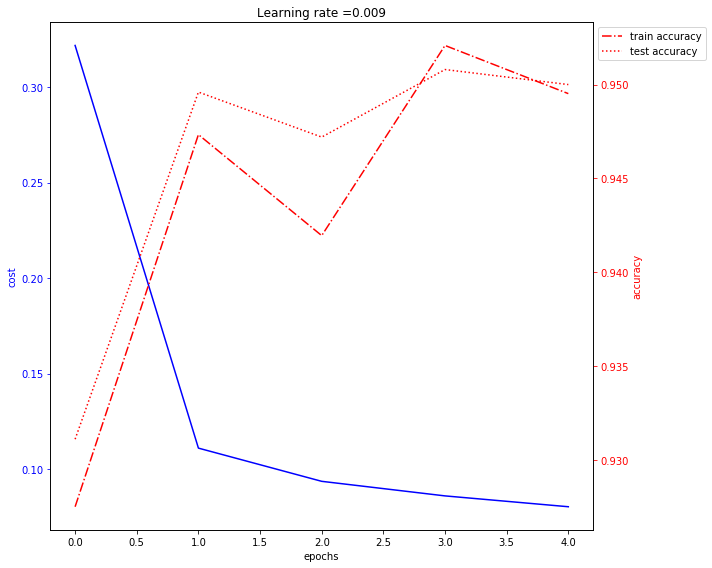

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.94951665
Test Accuracy: 0.95


In [18]:
parameters, costs, train_accuracy, test_accuracy = model(d_x_train, d_y_train, 
                                                         d_x_test, d_y_test, 
                                                         learning_rate = 0.009, 
                                                         num_epochs = 5)

In [ ]:
                # just a reminder that we can now plot outside the model training function
# plot_training_by_epoch (costs, train_accuracy, test_accuracy, learning_rate = 0.0001)

Training for 20 epochs (about 5.5 minutes on my intel Core i5-3380M laptop with no GPU), the model gets to about 94% training accuracy and 89.7% test accuracy with a training cost of 0.17, with the cost function still decreasing suggesting training still has a fair way to go. To speed up training I think an adaptive learning rate may be beneficial.

Trained for 60 epochs (about 15 minutes) made a substantial improvement in the training cost (0.06) resulting in a training accuracy of 98.8%. Interestingly, the model has a substantial variance problem, with the test accuracy reaching about 89% after about 10 epochs, and then essentially remaining static while the model over-fits to the training data.

In [ ]:
def predict(X, parameters):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (softmax: probability/confidence of each class)
    """

    # Retrieve the parameters from the dictionary "parameters"     
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    x = tf.placeholder("float", [784, None])  
            # IMPORTANT Note we need to use None here as we 
            # don't know how many training
            # examples will be passed in via feed_dict

                                                           
    Z1 = tf.add(tf.matmul(W1, X), b1)                      
    A1 = tf.nn.relu(Z1)                                    
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     
    A2 = tf.nn.relu(Z2)                                    
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     
    
    # Computes probabilities using forward propagation, 
    # and classifies to 0/1 using 0.5 as the threshold.
  
    p = tf.argmax(Z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

In [ ]:
def evaluate_predictions_byclass (X, Y, num_classes = 10):

    predict_set_X = X.astype(np.float32)
    # print ("predict_set_X:\n", predict_set_X)
    # predict_set_X = predict_set_X.reshape(2,1) 
    # predict_set_X.shape
    # type (predict_set_X[0,0]) # confirm type is float32

    prediction = predict (predict_set_X, parameters)
    print ("The model predicted:", prediction[0:9])
    print ("The correct labels are:\n", Y[0:9])
    
    evaluate_predictions = np.append(prediction.reshape(Y.shape), Y, axis=0)

    # get a vector of True/False values
    correct = (evaluate_predictions[0,:] == evaluate_predictions[1,:]) 
    print (correct[4000:4020])

    classes = np.arange(0, num_classes)

    # weight the bincount by True/False (ie only count correct responses)
    correct_by_class = np.bincount(evaluate_predictions[0,:], weights=correct) 
    totals_by_class = np.bincount(evaluate_predictions[1,:])

    accuracy_by_class = np.divide (correct_by_class, totals_by_class)
    return accuracy_by_class


In [ ]:
evaluate_predictions_byclass (dev_set_X, dev_set_Y)

The model suffers from accuracy on particularly on classes 0, 2, 4 and 6. 

# Error analysis

Let's see if we can get some insight into the types of errors the model is making and why, by visually inspecting some of the misclassified test items. First, we need to do a bit of data crunching on the vector of predictions (Y hat) and compare it to the correct answers (Y).

In [ ]:
predict_set_X = dev_set_X.astype(np.float32) # fix the data type

prediction = predict (predict_set_X, parameters) # get the vector of predictions (i.e. Y hat)
print ("The model predicted:", prediction[0:9])
print ("The correct labels are:", dev_set_Y[0,0:9])
    
# bind the prediction vector (Y hat) with the correct label vector (Y)
evaluate_predictions = np.append(prediction.reshape(dev_set_Y.shape), dev_set_Y, axis=0)

# turn that into a vector of True/False values
correct = (evaluate_predictions[0,:] == evaluate_predictions[1,:]) 
classes = np.arange(0, 10) # how many discrete classes do we have

# weight the bincount by True/False (ie only count correct responses)
correct_by_class = np.bincount(evaluate_predictions[0,:], weights=correct) 
totals_by_class = np.bincount(evaluate_predictions[1,:])

accuracy_by_class = np.divide (correct_by_class, totals_by_class) # as a percentage
print (accuracy_by_class)

Now let's look just at the errors on the dev set.

In [ ]:
print ("dev_set_Y.shape:", dev_set_Y.shape)


errors_Y = dev_set_Y[:,correct==False].T    # use the correct vector as a mask to make a vector of 
                                            #just the labels (Y) for incorrect predictions
print ("errors_Y.shape: ", errors_Y.shape)  # how many errors do we have?

# use the correct mask to get a vector of incorrect predictions (Y hat)
errors_Y_hat = prediction[correct==False].T 
errors_Y_hat = errors_Y_hat.reshape(errors_Y_hat.shape[0],1)
print ("errors_Y_hat.shape: ", errors_Y_hat.shape)

# use the mask to get the images for the errors  
errors_X = dev_set_X[:,correct==False]      
print ("errors_X.shape: ", errors_X.shape)

# transpose and make back into a 28x28 image
errors_X_2d = errors_X.T.reshape(errors_X.shape[1], 28, 28) 
print ("errors_X_2d.shape: ", errors_X_2d.shape)

rows = 4
cols = 4
fig, axarr = plt.subplots(rows, cols)

for r in range (0, rows):
    for c in range (0, cols):
        axarr[r][c].title.set_text("y: " + str(errors_Y[(r*cols)+c]) + "y_hat: " + str(errors_Y_hat[(r*cols)+c]) )
        axarr[r][c].imshow(errors_X_2d[(r*cols)+c])

## some ad-hoc hyperparameter tuning

Let's see if we can make any inroads into the variance problem. First of all, let's try adaptive learning rates using the AdagradOptimizer rather than Adam. (Because we want to try dropout, and Adam doesn't work with dropout) 

In [ ]:
parameters_ada, costs_ada, train_accuracy_ada, test_accuracy_ada = model(train_set_X, 
                                                         train_set_Y_one_hot, 
                                                         dev_set_X, dev_set_Y_one_hot, 
                                                         learn_algorithm = 'Adagrad',
                                                         learning_rate = 0.01, 
                                                         beta = 0.0, keep_prob = 1.0, 
                                                         num_epochs = 60)
                    # optimizer - Adam
                    # default layer sizes - layer_sizes = [784, 400, 150, 10]

Overall, the model not appreciably quicker to train (both Adagrad and Adam are adaptive learning algorithms) 

## Todo plot cost/test accuracy of Adagrad vs. Adam

Now let's try the Adagrad algorithm with dropout, to see if this helps fix the variance problem

## Model with Dropout

In [ ]:
parameters, costs, train_accuracy, test_accuracy = model(train_set_X, train_set_Y_one_hot, 
                                                         dev_set_X, dev_set_Y_one_hot, 
                                                         learn_algorithm = 'Adagrad',
                                                         learning_rate = 0.01, 
                                                         beta = 0.0, keep_prob = 0.8,
                                                         num_epochs = 60)

Implementing dropout (with a keep_prob of 0.8) does help a bit toward reducing overfitting (maybe 0.5% improvement in test set accuracy), at the cost of making training take longer.  

## Dropout AND L2 Regularization

In [ ]:
parameters, costs, train_accuracy, test_accuracy = model(train_set_X, train_set_Y_one_hot, 
                                                         dev_set_X, dev_set_Y_one_hot, 
                                                         learn_algorithm = 'Adagrad',
                                                         learning_rate = 0.01, 
                                                         beta = 0.001, keep_prob = 0.8,
                                                         num_epochs = 100)